In [390]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math
from scipy.interpolate import interp1d


In [391]:

def png_to_array(png_filepath):
    """
    Take a black and white PNG file, convert it to an array containing nan (for white pixels) and 1 (for black pixels)
    """
    # Convert image to black and white
    image = Image.open(png_filepath).convert('1')
    image_array = np.array(image)

    # Set black to 1 and white to NaN
    image_array = image_array.astype(float)
    image_array[image_array==1] = np.nan
    image_array[image_array==0] = int(1)

    return image_array


path = "/home/nickjdorsch/dev/apps/fault_impact/images/fault_fabric_1.png"

png_to_array(path)

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [392]:
def create_map(png_filepath, grid_spacing):
    # Load the image as a NumPy array
    img_array = png_to_array(png_filepath)
    # Get the dimensions of the image array
    height, width = img_array.shape
    
    # Calculate the aspect ratio of the image
    aspect_ratio = width / height

    x_distance = width * grid_spacing
    y_distance = height * grid_spacing

    print(x_distance, y_distance)

    # Create meshgrid of x and y coordinates in meters
    x = np.arange(0, x_distance, grid_spacing)
    y = np.arange(0, y_distance, grid_spacing)
    xx, yy = np.meshgrid(x, y)
    
    # Stack the meshgrid coordinates with the image array
    coords = np.dstack((xx, yy))
    map_array = np.concatenate((coords, img_array[:,:,np.newaxis]), axis=2)
    
    return map_array

In [393]:
# Plot the map
def plot_map(map_array):
    # Extract the x, y, and pixel value arrays from the map_array
    x = map_array[:,:,0]
    y = map_array[:,:,1]
    pixel_values = map_array[:,:,2]

    # Create a scatter plot of the pixel values
    fig, ax = plt.subplots()
    ax.scatter(x.flat, y.flat, c=pixel_values.flat, cmap='gray', s=0.1)
    ax.set_aspect('equal')
    ax.set_xlabel('X (meters)')
    ax.set_ylabel('Y (meters)')
    
    return fig, ax


14400 8100


/tmp/ipykernel_11686/2080459145.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


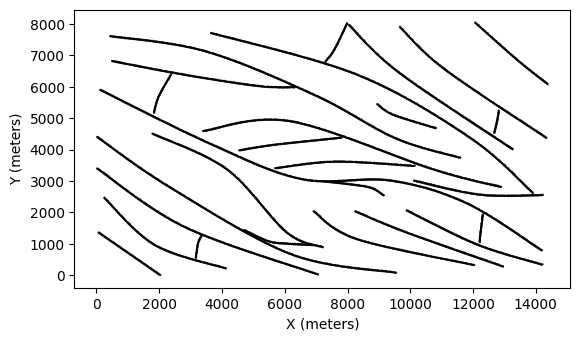

In [394]:
grid_spacing = 15
map_array = create_map(path, grid_spacing)

fig, ax = plot_map(map_array)

fig.show()

In [395]:
def get_values_along_line(image_array, x1, y1, x2, y2):
    """
    Plot a traverse on the map between two coordinates. 
    Return an array of every pixel value in the traverse.
    """

    # Find the grid spacing of the map
    grid_spacing = image_array[2,1,1] - image_array[1,1,1]

    # Check if the line is near-vertical
    if abs(x2 - x1) < grid_spacing*5:

        # Use y axis to interpolate function when it is near vertical
        # Swap coord values if necessary
        if y1 > y2:
            y1, y2 = y2, y1
            x1, x2 = x2, x1

        # Get range of y values as array
        y_range = np.arange(y1, y2+1, grid_spacing) 

        # Switch the roles of the x and y coordinates
        interp_func = interp1d([y1, y2], [x1, x2], kind="linear", bounds_error=False, fill_value="extrapolate")

        # Evaluate the function at the y coordinates
        x_coords = interp_func(y_range)

        # Convert coords to indices of the map
        x_indices = (x_coords / grid_spacing).astype(int)
        y_indices = (y_range / grid_spacing).astype(int)

    else:

        if x1 > x2:
            x1, x2 = x2, x1
            y1, y2 = y2, y1

        # Get range of y values as array
        x_range = np.arange(x1, x2+1, grid_spacing) 

        # Define a function that interpolates values along the line between the coordinates
        interp_func = interp1d([x1, x2], [y1, y2], kind="linear", bounds_error=False, fill_value="extrapolate")

        # Evaluate the function at the x coordinates
        y_coords = interp_func(x_range)
        
        # Convert coords to indices of the map
        x_indices = (x_range / grid_spacing).astype(int)
        y_indices = (y_coords / grid_spacing).astype(int)
    
    # Extract the values along the line from the image array between x1 and x2
    mid_array = image_array[y_indices, x_indices]

    # calculate additional arrays above, below, left and right of the traverse_array
    top_array = image_array[y_indices+1, x_indices]
    bottom_array = image_array[y_indices-1, x_indices]
    left_array = image_array[y_indices, x_indices-1]
    right_array = image_array[y_indices, x_indices+1]


    # Bring arrays together into a single master array
    traverse_array = np.stack((mid_array, top_array, bottom_array, left_array, right_array), axis=1)

    # List the pixel values
    pixel_values = traverse_array[:,2]
    
    return traverse_array

In [396]:
traverse_array = get_values_along_line(map_array, 0, 0, 4000, 6000)
traverse_pixels = traverse_array[:,:,2]

print(traverse_pixels[:10])

[[nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]]


In [397]:
def count_fault_crossings(traverse_array, block_size):
    """
    Take the one dimensional array of pixel values from the map traverse and sum blocks containing a non NaN element (corresponding to a fault)
    Discount consecutive non NaN values (duplicate pixel values, only counts as one fault crossing)
    """

    # Extract only the pixel values from the traverse array
    pixels = traverse_array[:,:,2]
    
    count = 0
    sum = 0
    for i in range(0, len(pixels), block_size):

        # Loop through array in blocks of size block_size
        block = pixels[i:i+block_size]

        # add to the sum if the block contains any 1 values, but do not count consecutive blocks
        if np.any(block == 1) and count == 0:
            count += 1
            sum +=1

        else:
            count = 0
            
    return sum


In [398]:
def traverse_map_at_bearing(map_array, start_point, bearing_degrees, distance_meters):

    # Convert the bearing to radians (subtract from 90 to convert to clockwise from north)
    bearing_radians = math.radians(90 - bearing_degrees)

    # Get the map dimensions to check if the end point is beyond them
    map_width = map_array[:,:,0].max()
    map_height = map_array[:,:,1].max()

    # Calculate the end point
    x0, y0 = start_point
    x1 = x0 + distance_meters * math.cos(bearing_radians)
    y1 = y0 + distance_meters * math.sin(bearing_radians)

    # Find the grid spacing of the map
    grid_spacing = map_array[2,1,1] - map_array[1,1,1]

    grid_buffer = grid_spacing * 5

    # Check if end point is outside of the map boundaries and truncate where necessary
    if x1 < (grid_buffer):
        x1 = grid_buffer

    if x1 >= map_width - grid_buffer:
        x1 = map_width - grid_buffer

    if y1 < grid_buffer:
        y1 = grid_buffer

    if y1 >= map_height - grid_buffer:
        y1 = map_height - grid_buffer

        
    # Pack coords into array
    coords = [[x0, y0],[x1,y1]]

    # Get all values along the interpolated line
    values = get_values_along_line(map_array, start_point[0], start_point[1], x1, y1)

    # Calculate length of traversal
    length = math.sqrt((x1 - x0)**2 + (y1 - y0)**2)

    return coords, values, length


Distance: 10000.0
Fault Crossings: 8
Fault Density = 0.8


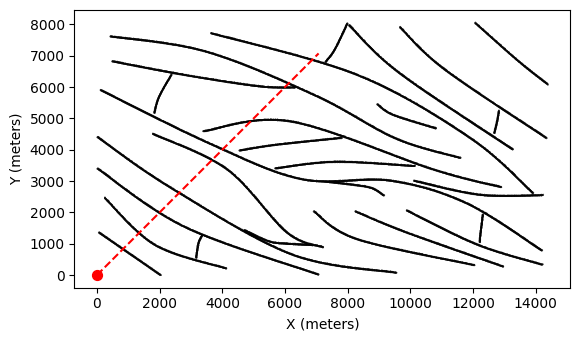

In [399]:
"""
Test Traversal Function
"""

coords, values, length = traverse_map_at_bearing(map_array, (0, 0), 45, 10_000)

# Count fault crossings
fault_crossings = count_fault_crossings(values, 20)

fault_density = fault_crossings * 1000 / length

fig, ax = plot_map(map_array)

# add traversal to map
x = [coords[0][0], coords[1][0]]
y = [coords[0][1], coords[1][1]]

# Plot the line
plt.scatter(x[0], y[0], c="red", s=50)

plt.plot(x, y, c="red", linestyle="dashed")

print(f"Distance: {length}")
print(f"Fault Crossings: {fault_crossings}")
print(f"Fault Density = {fault_density}")

In [400]:
def random_map_position(map_array, edge_distance):
    """
    Plot a random position on a map array, with a defined distance from the edges
    """

    # Find the grid spacing of the map
    grid_spacing = map_array[2,1,1] - map_array[1,1,1]

    # Get range of x and y axes
    x_range = np.ptp(map_array[:,:,0])
    y_range = np.ptp(map_array[:,:,1])

    # Truncate the ranges, add 1 to edge distance to avoid edge index error
    x_truncated_range = np.arange(
        edge_distance+1,
        (x_range - (edge_distance+1)),
        grid_spacing,
    )
    y_truncated_range = np.arange(
        edge_distance+1,
        (y_range - (edge_distance+1)),
        grid_spacing,
    )

    # Generate random coordinates within the ranges
    rand_x = np.random.choice(x_truncated_range)
    rand_y = np.random.choice(y_truncated_range)

    return [rand_x, rand_y]

    

In [401]:
random_map_position(map_array, 2000)

[3186.0, 4161.0]

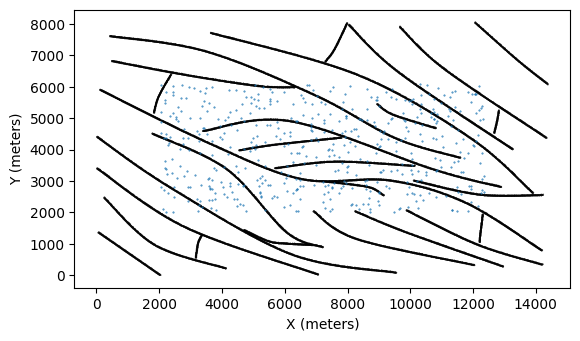

In [402]:
points = []
for i in range(500):
    random_coord = random_map_position(map_array, 2000)

    points.append(random_coord)


plot_map(map_array)

plt.scatter(*zip(*points), s=0.2)


In [403]:
def fault_crossing_simulation(map_array, distance, buffer, sims):
    """
    Drop random points on the map, traverse for a defined distance at a random azimuth and count the number of faults crossed
    Aggregate data into a list binned by azimuth
    """

    # Simulation loop
    data = []
    for i in range(sims):

        # Random starting point within distance buffer
        random_coord = random_map_position(map_array, buffer)

        # Plot a traverse from the random coord along a randomly chosen azimuth
        azimuth = np.random.random() * 360
        destination, values, traverse_distance = traverse_map_at_bearing(map_array, random_coord, azimuth, distance)

        # Count fault crossings in path
        fault_crossings = count_fault_crossings(values, block_size=20)

        # Calculate fault density (per km)
        fault_density = fault_crossings * 1000 / traverse_distance

        # Return an array of the path azimuth, and fault density
        result = [azimuth, fault_crossings, fault_density]

        # Append to data array
        data.append(result)

    return np.array(data)


In [404]:
data = fault_crossing_simulation(map_array, 3000, 3000, 2000)

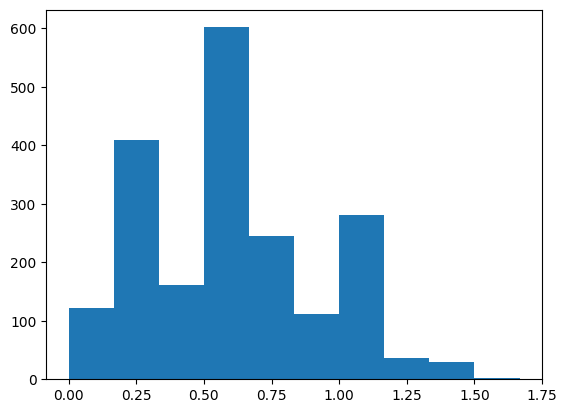

In [405]:
plt.hist(data[:,2])
plt.show()

In [406]:
import pandas as pd

# create a DataFrame
df = pd.DataFrame(data=data, columns=['azimuth', 'fault_encounters', 'fault_density'])

df

,azimuth,fault_encounters,fault_density
0,234.744911,3.0,1.000000
1,283.641445,2.0,0.666667
2,143.784893,2.0,0.666667
3,132.699565,2.0,0.666667
4,298.364786,2.0,0.666667
...,...,...,...
1995,238.994723,2.0,0.666667
1996,214.302062,3.0,1.000000
1997,257.805622,2.0,0.666667
1998,54.748946,3.0,1.000000


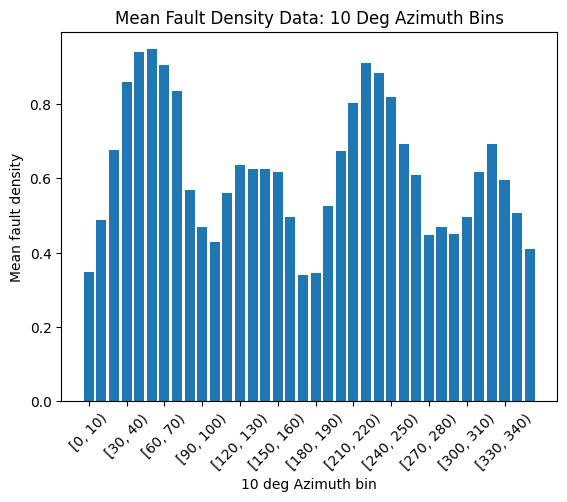

In [407]:
# Bin the azimuth data
azimuth_bins = pd.cut(df['azimuth'], bins=range(0, 361, 10), right=False, include_lowest=True)
df['azimuth_bin'] = azimuth_bins

# Group the data by azimuth bin and compute the mean fault density in each bin
binned_data = df.groupby('azimuth_bin')['fault_density'].mean()

# Create a bar chart of the binned data
plt.bar(binned_data.index.astype(str), binned_data.values)

# Add x-axis label and tick labels
plt.title("Mean Fault Density Data: 10 Deg Azimuth Bins")
plt.xlabel('10 deg Azimuth bin')
plt.xticks(binned_data.index[::3].astype(str), rotation=45)

# Add y-axis label
plt.ylabel('Mean fault density')

# Show the plot
plt.show()

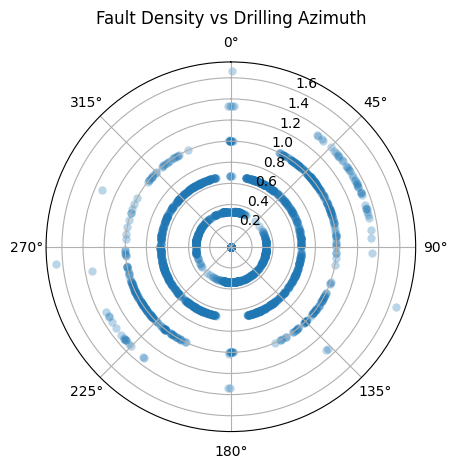

In [408]:
r = df["fault_density"]

# convert azimuth column to rads
theta = np.deg2rad(df["azimuth"])

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.scatter(theta, r, alpha=0.3, edgecolor=None, linewidth=0)
#ax.set_rticks([0.5, 1, 1.5, 2])  # Less radial ticks
#ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
ax.set_theta_direction(-1)
ax.set_theta_offset(np.pi / 2.0)
ax.grid(True)

ax.set_title("Fault Density vs Drilling Azimuth", va='bottom')
plt.show()